# Taxi Fare Prediction using Chicago Taxi-cab dataset

## Table of Contents
* [Overview](#section-1)
* [Dataset](#section-2)
* [Objective](#section-3)
* [Costs](#section-4)
* [Data Analysis](#section-5)
* [Fit a Simple Linear Regression model](#section-6)
* [Save the model and upload to a GCS bucket](#section-7)
* [Deploy the Model on Vertex-AI with support for Explanations](#section-8)
* [Get explanations from the deployed model](#section-9)
* [Clean Up](#section-10)

## Overview
<a name="section-1"></a>

This notebooks demonstrates analysis, feature selection, model building and deployment with explanations configured on Vertex-AI on a subset of the Chicago Taxi-cab dataset for Taxi-fare prediction problem.

Note: This notebook file was developed to run in a [Vertex AI Workbench managed notebooks](https://console.cloud.google.com/vertex-ai/workbench/list/managed) instance using the Python(Local) kernel. Some components of this notebook may not work in other notebook environments.

## Dataset
<a name="section-2"></a>

The Chicago Taxi-cab dataset includes taxi trips from 2013 to the present, reported to the City of Chicago in its role as a regulatory agency. To protect privacy but allow for aggregate analyses, the Taxi ID is consistent for any given taxi medallion number but does not show the number, Census Tracts are suppressed in some cases, and times are rounded to the nearest 15 minutes. Due to the data reporting process, not all trips are reported but the City believes that most are. This dataset is publicly available on Bigquery under the public datasets with the Table ID : `bigquery-public-data.chicago_taxi_trips.taxi_trips` and also as public dataset on Kaggle Datasets at : [Chicago Taxi Trips Dataset](https://www.kaggle.com/chicago/chicago-taxi-trips-bq).

 For more information about this dataset and how it was created, please refer [Chicago Digital website](http://digital.cityofchicago.org/index.php/chicago-taxi-data-released).

## Objective
<a name="section-3"></a>

The goal of this notebook is to provide an overview on the latest Vertex-AI features like Explainable AI  and Bigquery in Notebook by trying to solve a Taxi-fare prediction problem. The steps followed in this notebook include : 

- Loading the dataset using `Bigquery in Notebooks`
- Performing Exploratory Data Analysis on the dataset
- Feature selection and preprocessing
- Building a linear regression model using Sklearn
- Configuring the model for explanations
- Deploying the model to Vertex-AI
- Testing the deployed model
- Clean up

## Costs
<a name="section-4"></a>

This tutorial uses the following billable components of Google Cloud:

- Vertex AI
- Bigquery
- Cloud Storage


Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [Bigquery pricing](https://cloud.google.com/bigquery/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Set your project ID

In [ ]:
PROJECT = "[your-project-id]"

## Select or Create Cloud Storage Bucket for storing the model

When you create a model resource on Vertex-AI using the Cloud SDK, you need to give a Cloud Storage bucket uri of the model where the model is stored. Using the model saved, you can then create Vertex AI model and endpoint resources in order to serve online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all Cloud Storage buckets.You may also change the REGION variable, which is used for operations throughout the rest of this notebook. Make sure to choose a region where Vertex AI services are available.

In [ ]:
BUCKET_NAME = "[your-bucket-name]"
BUCKET_URI = f"gs://{BUCKET_NAME}"
LOCATION = "us-central1"

In [ ]:
## Set a default bucketname in case bucket name is not given
if BUCKET_NAME == "" or BUCKET_NAME is None :
    from datetime import datetime
    
    TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
    BUCKET_NAME =  PROJECT_ID + "aip-" + TIMESTAMP
    BUCKET_URI = "gs://" +BUCKET_NAME

<b>Only if your bucket doesn't already exist</b>: Run the following cell to create your Cloud Storage bucket.

## Import the required libraries and define constants

In [ ]:
! gsutil mb -l $REGION $BUCKET_NAME

Next, validate access to your Cloud Storage bucket by examining its contents:

In [ ]:
! gsutil ls -al $BUCKET_NAME

In [1]:
# load the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

The dataset is quite a large and noisy one and so data from a specific date range will be used. Based on various blogs and resources that are available online, many of them seem to have used the data from around May-2018 which gave some really good results compared to the other date ranges. While there are also some complicated research models propsed for the same problem like considering the weather data, holidays and seasons etc., the current notebook only explores a simple linear regression model as our main objective is to demonstrate the model deployment with explanations configured on Vertex-AI.

## Accessing the data through Bigquery in Notebooks
`Bigquery in Notebooks` feature of Vertex-AI's managed notebooks allows us to use Bigquery and its features from the notebook itself eliminating the need to switch between tabs everytime. For every cell in the notebook, there is an option for Bigquery integration at the top right selecting which would enable us to compose a SQL query that can be executed in Bigquery. 

The chosen dataset consists of the following fields :
- `unique_key` : Unique identifier for the trip.
- `taxi_id` : A unique identifier for the taxi.
- `trip_start_timestamp`: When the trip started, rounded to the nearest 15 minutes.
- `trip_end_timestamp`: When the trip ended, rounded to the nearest 15 minutes.
- `trip_seconds`: Time of the trip in seconds.
- `trip_miles`: Distance of the trip in miles.
- `pickup_census_tract`: The Census Tract where the trip began. For privacy, this Census Tract is not shown for some trips.
- `dropoff_census_tract`: The Census Tract where the trip ended. For privacy, this Census Tract is not shown for some trips.
- `pickup_community_area`: The Community Area where the trip began.
- `dropoff_community_area`: The Community Area where the trip ended.
- `fare`: The fare for the trip.
- `tips`: The tip for the trip. Cash tips generally will not be recorded.
- `tolls`: The tolls for the trip.
- `extras`: Extra charges for the trip.
- `trip_total`: Total cost of the trip, the total of the fare, tips, tolls, and extras.
- `payment_type`: Type of payment for the trip.
- `company`: The taxi company.
- `pickup_latitude`: The latitude of the center of the pickup census tract or the community area if the census tract has been hidden for privacy.
- `pickup_longitude`: The longitude of the center of the pickup census tract or the community area if the census tract has been hidden for privacy.
- `pickup_location`: The location of the center of the pickup census tract or the community area if the census tract has been hidden for privacy.
- `dropoff_latitude`: The latitude of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy.
- `dropoff_longitude`: The longitude of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy.
- `dropoff_location`: The location of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy.

Among the available fields in the dataset, only the fields that seem common and relevant for analysis and modeling like `taxi_id`, `trip_start_timestamp`, `trip_seconds`, `trip_miles`, `payment_type` and `trip_total` are selected. Further, the field `trip_total` is treated as the target variable that would be predicted by the machine learning model. Apparently, this field is a summation of `fare`,`tips`,`tolls` and `extras` fields and so because of their correlation with the target variable, they are being excluded for modeling. Due to the volume of the data, a subset of the dataset over the course of one week i.e., 12-May-2018 to 18-May-2018 is being considered. Within this date range itself, the datapoints can be noisy and so a few conditions like the following are considered : 

- Time taken for the trip > 0.
- Distance covered during the trip > 0.
- Total trip charges > 0 and
- Pickup and dropoff areas are valid(not empty).

#@bigquery

select 
-- select the required fields
taxi_id, trip_start_timestamp, 
trip_seconds, trip_miles, trip_total, 
payment_type

from `bigquery-public-data.chicago_taxi_trips.taxi_trips` 
where 
-- specify the required criteria
trip_start_timestamp >= '2018-05-12' and 
trip_end_timestamp <= '2018-05-18' and
trip_seconds > 0 and
trip_miles > 0 and
trip_total > 3 and
pickup_community_area is not NULL and 
dropoff_community_area is not NULL


The Bigquery integration also allows us to load the queried data into a pandas dataframe using the `Query and load as DataFrame` button. Clicking the button adds a new cell below that provides a code snippet to load the data into a dataframe.

In [17]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """select 
taxi_id, trip_start_timestamp, 
trip_seconds, trip_miles, trip_total, 
payment_type, pickup_community_area, 
dropoff_community_area 

from `bigquery-public-data.chicago_taxi_trips.taxi_trips` 
where 
trip_start_timestamp >= '2018-05-12' and 
trip_end_timestamp <= '2018-05-18' and
trip_seconds > 0 and trip_seconds < 6*60*60 and
trip_miles > 0 and
trip_total > 3 and
pickup_community_area is not NULL and 
dropoff_community_area is not NULL"""
job = client.query(query)
df = job.to_dataframe()

Check the fields in the data and the shape.

In [18]:
## check the dataframe's shape
print (df.shape)
## check the columns in the dataframe
df.columns

(278678, 8)


Index(['taxi_id', 'trip_start_timestamp', 'trip_seconds', 'trip_miles',
       'trip_total', 'payment_type', 'pickup_community_area',
       'dropoff_community_area'],
      dtype='object')

Check some sample data.

In [19]:
df.head()

,taxi_id,trip_start_timestamp,trip_seconds,trip_miles,trip_total,payment_type,pickup_community_area,dropoff_community_area
0,1833edab9ed696386a8224986104fd046eaf9ea8dffb9e...,2018-05-17 11:15:00+00:00,33,0.1,6.75,Credit Card,32,32
1,58c784c628cc2b0b77468e6a406acea729301abbc17a62...,2018-05-13 00:15:00+00:00,65,0.1,5.50,Credit Card,8,8
2,0300862a19483bcacac6176544abf331b8a3d41ec6efda...,2018-05-13 18:45:00+00:00,65,0.1,3.75,Cash,11,11
3,cf201b86531ed045f2aba753831f73b9839ab42281b703...,2018-05-13 00:00:00+00:00,84,0.1,3.75,Cash,8,8
4,a2f43960996408dea7a7a313753317981e812219c9e040...,2018-05-14 02:00:00+00:00,70,0.4,5.00,Cash,8,8


Check the dtypes of fields in the data.

In [20]:
df.dtypes

taxi_id                                object
trip_start_timestamp      datetime64[ns, UTC]
trip_seconds                            int64
trip_miles                            float64
trip_total                            float64
payment_type                           object
pickup_community_area                   int64
dropoff_community_area                  int64
dtype: object

Check for null values in the dataframe.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278678 entries, 0 to 278677
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   taxi_id                 278678 non-null  object             
 1   trip_start_timestamp    278678 non-null  datetime64[ns, UTC]
 2   trip_seconds            278678 non-null  int64              
 3   trip_miles              278678 non-null  float64            
 4   trip_total              278678 non-null  float64            
 5   payment_type            278678 non-null  object             
 6   pickup_community_area   278678 non-null  int64              
 7   dropoff_community_area  278678 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(2)
memory usage: 17.0+ MB


Depending on the percentage of null values in the data, one can choose to either drop them or impute them with mean/median(for numerical values) and mode(for categorical values). In the current data, there doesn't seem to be any null values.

Check the numerical distributions of the fields(numerical). In case there are any fields with constant values, those fields can be dropped as they don't add any value to the model.

In [22]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trip_seconds,278678.0,895.686875,881.699588,1.00,360.0,599.0,1020.00,20265.00
trip_miles,278678.0,4.086207,5.809640,0.01,0.9,1.5,4.00,813.00
trip_total,278678.0,17.128208,20.883550,3.01,7.5,10.0,17.25,6155.91
pickup_community_area,278678.0,25.525133,20.430918,1.00,8.0,28.0,32.00,77.00
dropoff_community_area,278678.0,22.657479,17.978810,1.00,8.0,24.0,32.00,77.00


In the current dataset, `trip_total` is the target field. To access the fields by their type easily, identify the categorical and numerical fields in the data and save them.

In [23]:
target = "trip_total"
categ_cols = ['payment_type','pickup_community_area','dropoff_community_area']
num_cols = ['trip_seconds','trip_miles']

## Analyze numerical data
<a name="section-5"></a>

To further anaylyze the data, there are various plots that can be used on numerical and categorical fields. In case of numerical data, one can use histograms and box-plots while bar charts(distribution plots) are more suited for categorical data to better understand the distribution of the data and the outliers in the data.

Plot Histograms and Box-plots on the numerical fields.

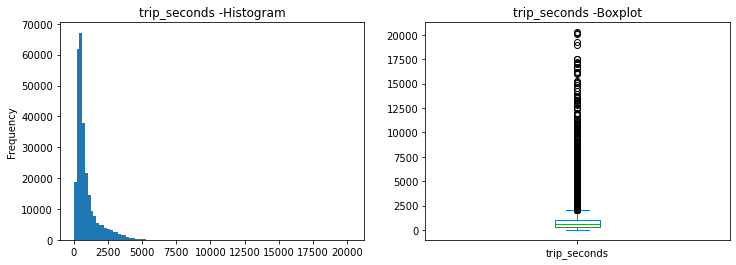

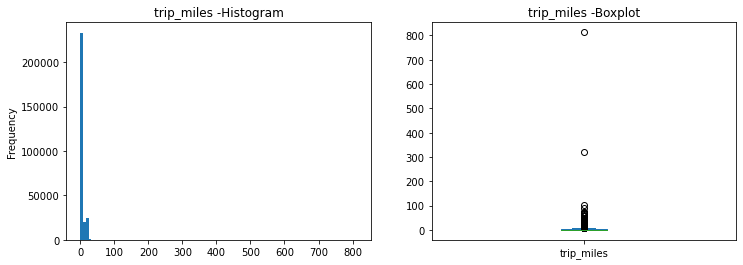

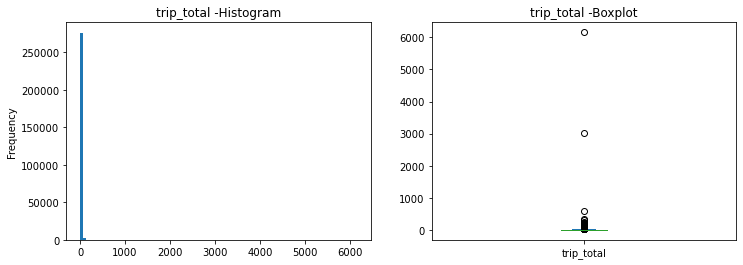

In [24]:
for i in num_cols+[target] :
    _, ax = plt.subplots(1,2,figsize=(12,4))
    df[i].plot(kind='hist',bins=100, ax=ax[0])
    ax[0].set_title(str(i) + ' -Histogram')
    df[i].plot(kind='box', ax=ax[1])
    ax[1].set_title(str(i) + ' -Boxplot')
    plt.show()

The field `trip_seconds` describes the time taken for the trip in seconds. Optionally, it can be converted into hours for an easier understanding.

<AxesSubplot:>

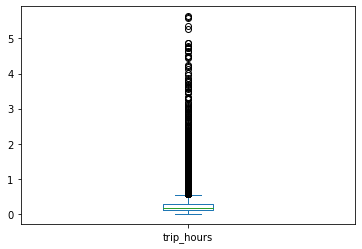

In [25]:
df['trip_hours'] = round(df['trip_seconds']/3600,2)
df['trip_hours'].plot(kind='box')

Similarly, another field `trip_speed` can be added by dividing `trip_miles` and `trip_hours` to understand the speed of the trip in miles/hour.

<AxesSubplot:>

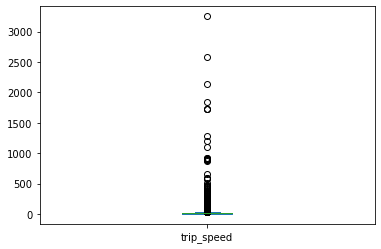

In [26]:
df['trip_speed'] = round(df['trip_miles']/df['trip_hours'],2)
df['trip_speed'].plot(kind='box')

So far we've only considered to look at the univariate plots. To better understand the relationship between the variables, a pair-plot can be plotted.

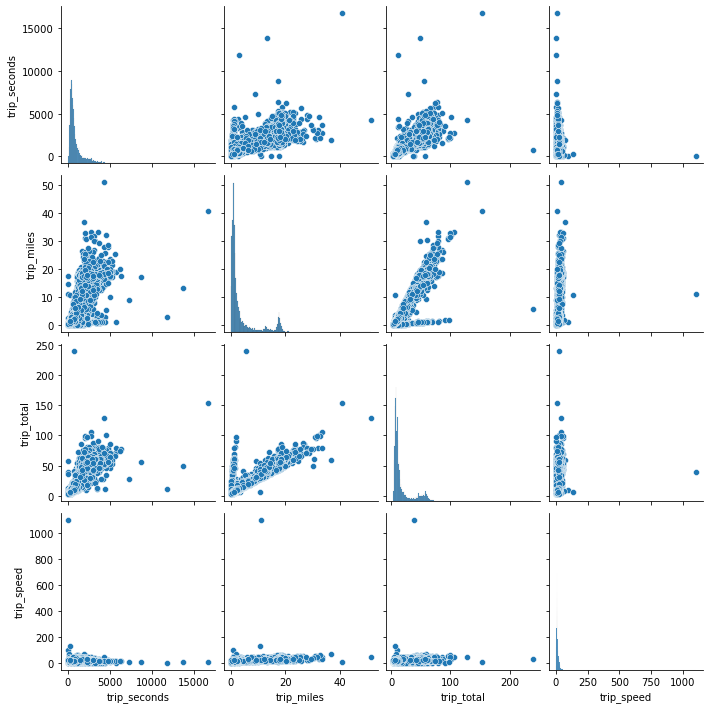

In [27]:
sns.pairplot(data=df[['trip_seconds','trip_miles','trip_total', 'trip_speed']].sample(10000))
plt.show()

From the box-plots and the histograms plotted so far, it is evident that there are some outliers causing skewness in the data which perhaps could be removed. Also, we can certainly see some linear relationship between the independent variables considered in the pair-plot i.e., `trip_seconds` and `trip_miles` and the dependant variable `trip_total`.

Restrict the data based on the following conditions to remove the outliers in the data to some extent :
- Total charge being at least more than $3.
- Total miles driven greater than 0 and less than 300 miles.
- Total seconds driven at least 1 minute.
- Total hours driven not more than 2 hours.
- Speed of the trip not being more than 70 mph.

These conditions are based on some general assumptions as clearly there were some recording errors like speed being greater than 500 mph and travel-time being more than 5 hours that led to outliers in the data. 

In [28]:
## set constraints to remove outliers
df = df[df['trip_total'] > 3]

df = df[(df['trip_miles'] > 0)&(df['trip_miles']<300)]

df = df[df['trip_seconds']>=60]

df = df[df['trip_hours']<=2]

df = df[df['trip_speed']<=70]
df.reset_index(drop=True, inplace=True)
df.shape

(277386, 10)

## Analyze Categorical data

Further, explore the categorical data by plotting the distribution of all the levels in each field.

(8,)


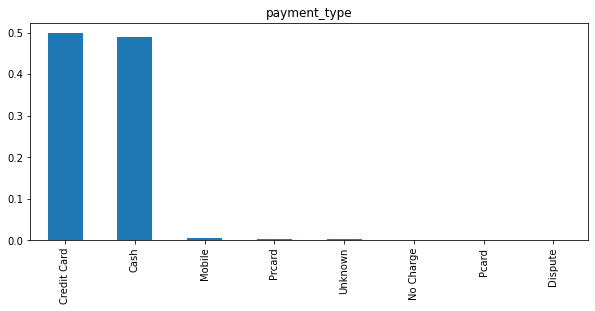

(77,)


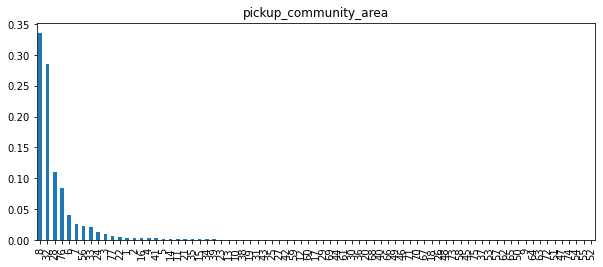

(77,)


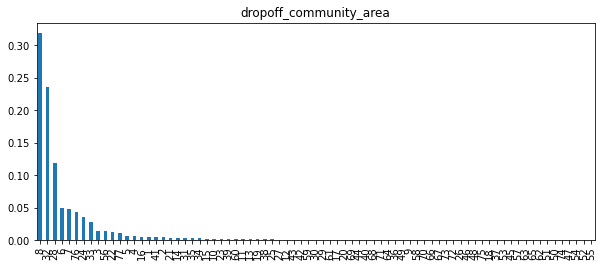

In [29]:
for i in categ_cols :
    print (df[i].unique().shape)
    df[i].value_counts(normalize=True).plot(kind='bar',figsize=(10,4))
    plt.title(i)
    plt.show()

From the above analysis, one can see that almost 99% of the transaction types are Cash and Credit Card. While there are also other type of transactions, their distribution is very less. In such a case, the lower distribution levels can be dropped. On the other hand, total number of pickup and dropoff community areas both seem to have the same levels which make sense. In this case also, one can choose to omit the lower distribution levels but it has to be made sure that both the fields have the same levels afterwards. In the current notebook, we'd keep them as it is and proceed with the modeling.

The relationships between the target variable and the categorical fields can be represented through boxplots. For each level, the corresponding distribution of the target variable can be identified.

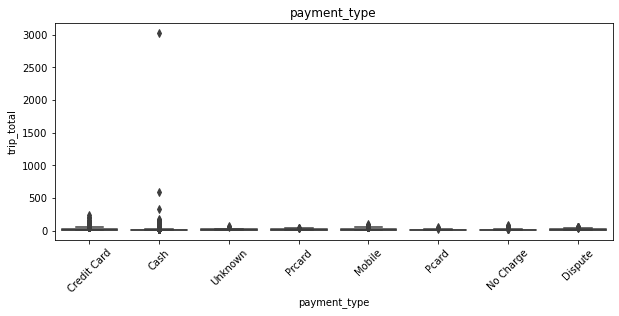

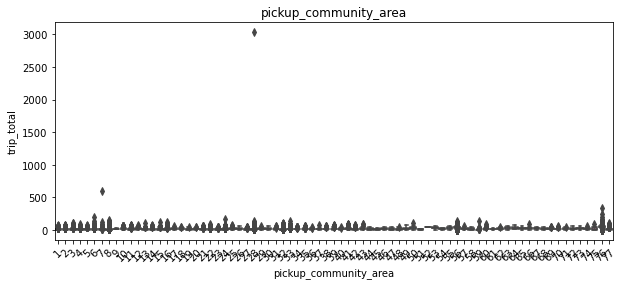

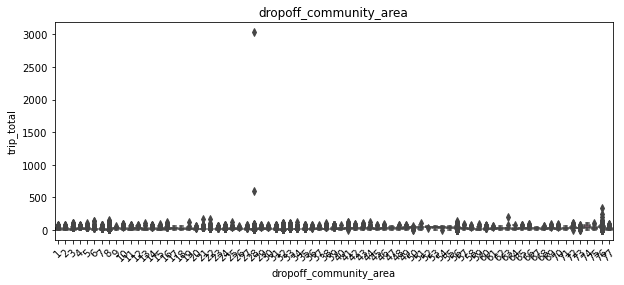

In [31]:
for i in categ_cols :
    plt.figure(figsize=(10,4))
    sns.boxplot(x=i,y=target,data=df)
    plt.xticks(rotation=45)
    plt.title(i)
    plt.show()

There seems to be one case where the `trip_total` is over 3000 and has the same pickup and dropoff community area i.e., 28 which is clearly an outlier compared to the rest of the points. This datapoint can be removed.

In [32]:
df = df[df['trip_total']<3000].reset_index(drop=True)

Keep only the `Credit Card` and `Cash` payment types. Further, encode them by assigning 0 for `Credit Card` and 1 for `Cash` payment types.

In [38]:
## add payment_type
df = df[df['payment_type'].isin(['Credit Card', 'Cash'])].reset_index(drop=True)
## encode the payment types
df['payment_type'] = df['payment_type'].apply(lambda x: 0 if x == 'Credit Card' else (1 if x == 'Cash' else None))

There are also timestamp fields in the data that can prove to be useful. `trip_start_timestamp` represents the start timestamp of the taxi-trip and fields like what day of week it was and what hour it was can be dervied from it.

In [33]:
df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])
df['dayofweek'] = df['trip_start_timestamp'].dt.dayofweek
df['hour'] = df['trip_start_timestamp'].dt.hour

Since the current dataset is considered only for a week, if there isn't much variation in the newly dervied fields with respect to the target variable, they can be dropped.

Plot sum and average of the `trip_total` with respect to the `dayofweek`.

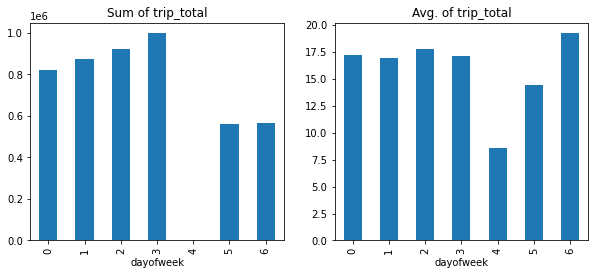

In [34]:
## plot sum and average of trip_total w.r.t the dayofweek
_, ax = plt.subplots(1,2,figsize=(10,4))
df[['dayofweek','trip_total']].groupby('dayofweek').trip_total.sum().plot(kind='bar',ax=ax[0])
ax[0].set_title("Sum of trip_total")
df[['dayofweek','trip_total']].groupby('dayofweek').trip_total.mean().plot(kind='bar',ax=ax[1])
ax[1].set_title("Avg. of trip_total")
plt.show()

Plot sum and average of the `trip_total` with respect to the `hour`.

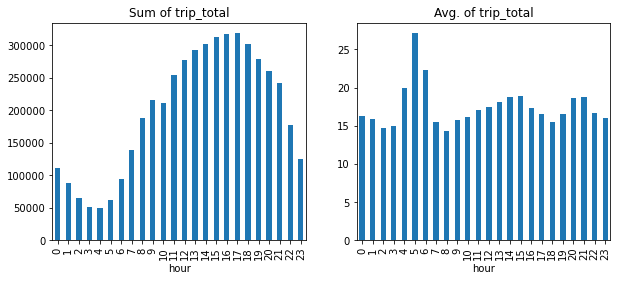

In [ ]:
_, ax = plt.subplots(1,2,figsize=(10,4))
df[['hour','trip_total']].groupby('hour').trip_total.sum().plot(kind='bar',ax=ax[0])
ax[0].set_title("Sum of trip_total")
df[['hour','trip_total']].groupby('hour').trip_total.mean().plot(kind='bar',ax=ax[1])
ax[1].set_title("Avg. of trip_total")
plt.show()

As these plots don't seem to have constant figures with respect to the target variable across their levels, they can be considered for training. In fact, to simplify things these dervied features can be bucketed into less number of levels.

`dayofweek` field can be bucketed into a binary field considering whether or not it was a weekend. If it is a weekday, the record can be assigned 1, else 0. Similarly, `hour` field can also be bucketed and encoded. The normal working hours in Chicago can be assumed to be between *8AM*-*10PM* and if the value falls in between the working hours, it can be encoded as 1, else 0.

In [35]:
## bucket and encode the dayofweek and hour
df['dayofweek'] = df['dayofweek'].apply(lambda x : 0 if x in [5,6] else 1)
df['hour'] = df['hour'].apply(lambda x: 0 if x in [23,0,1,2,3,4,5,6,7] else 1)

Check the data distribution before training the model.

In [127]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trip_seconds,273862.0,892.965694,852.294942,60.00,360.0,599.00,1020.00,7206.0
trip_miles,273862.0,4.073097,5.544775,0.01,0.9,1.50,4.00,71.5
trip_total,273862.0,17.089971,17.291648,3.01,7.5,10.00,17.10,3030.3
payment_type,273862.0,0.495228,0.499978,0.00,0.0,0.00,1.00,1.0
pickup_community_area,273862.0,25.482236,20.406290,1.00,8.0,28.00,32.00,77.0
dropoff_community_area,273862.0,22.582783,17.911476,1.00,8.0,24.00,32.00,77.0
trip_hours,273862.0,0.248034,0.236760,0.02,0.1,0.17,0.28,2.0
trip_speed,273862.0,13.577049,8.706641,0.02,8.0,11.00,16.67,70.0
dayofweek,273862.0,0.754581,0.430336,0.00,1.0,1.00,1.00,1.0
hour,273862.0,0.833518,0.372513,0.00,1.0,1.00,1.00,1.0


## Divide the data in Train and Test sets

Split the preprocessed dataset into train and test sets so that the linear regression model can be validated on the test set.

In [39]:
cols = ['trip_seconds', 'trip_miles', 'payment_type','pickup_community_area',
             'dropoff_community_area','dayofweek', 'hour','trip_speed']
x = df[cols].copy()
y = df[target].copy()

## split the data into 75-25% ratio
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.75, test_size=0.25, random_state=13)
X_train.shape, X_test.shape

((205395, 8), (68466, 8))

## Fit a Simple Linear Regression model
<a name="section-6"></a>

Fit a linear regression model using Sklearn's LinearRegression method on the train data.

In [40]:
# Building the regression model
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression()

Print the `R2 score` and `RMSE` values for the model on train and test sets.

In [41]:
## print test R2 score
y_train_pred = reg.predict(X_train)
train_score = r2_score(y_train, y_train_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
y_test_pred = reg.predict(X_test)
test_score = r2_score(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print ("Train R2-score:",train_score,"Train RMSE:",train_rmse)
print ("Test R2-score:",test_score,"Test RMSE:",test_rmse)

Train R2-score: 0.934937407792465 Train RMSE: 4.156837818607167
Test R2-score: 0.9353978031623289 Test RMSE: 4.150444740081971


A low RMSE error and a train and test R2 score of 0.93 suggests that the model has fitted well on the data. Further, the coefficients learned by the model for each of its independent variables can also be checked by checking the `coef_` attribute of the sklearn model. 

Check the coefficients learned by the model.

<AxesSubplot:xlabel='col'>

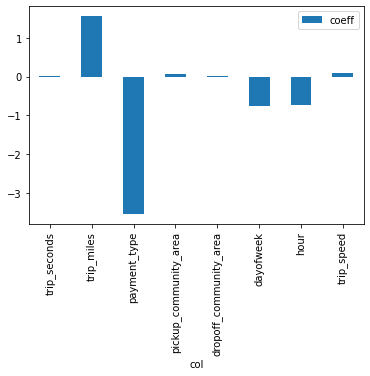

In [42]:
coef_df = pd.DataFrame({"col":cols, "coeff":reg.coef_})
coef_df.set_index("col").plot(kind='bar')

## Save the model and upload to a GCS bucket.
<a name="section-7"></a>

To deploy the model on Vertex-AI, the model needs to be stored in a cloud storage bucket first.

In [140]:
import joblib
from google.cloud import storage

FILE_NAME = "model.joblib"
joblib.dump(reg, FILE_NAME)

# Upload the saved model file to Cloud Storage
BLOB_PATH = "taxicab_fare_prediction/"

BLOB_NAME = BLOB_PATH + FILE_NAME

bucket = storage.Client().bucket(BUCKET_NAME)
blob = bucket.blob(BLOB_NAME)
blob.upload_from_filename(FILE_NAME)

## Deploy the Model on Vertex-AI with support for Explanations
<a name="section-8"></a>

Configure the explanations before deploying the model. For further details, see [Configuring explanations in Vertex AI models](https://cloud.google.com/vertex-ai/docs/explainable-ai/configuring-explanations#scikit-learn-and-xgboost-pre-built-containers).

In [142]:
MODEL_DISPLAY_NAME = "taxi_fare_prediction_model"
ARTIFACT_GCS_PATH = f"gs://{BUCKET_NAME}/{BLOB_PATH}"

# Feature-name(Inp_feature) and Output-name(Model_output) can be arbitrary
exp_metadata = {"inputs": {"Input_feature": {}}, "outputs": {"Predicted_taxi_fare": {}}}

Create a model resource from the uploaded model with explanation metadata configured.

In [ ]:
from google.cloud import aiplatform
from google.cloud.aiplatform_v1.types.explanation import ExplanationParameters
from google.cloud.aiplatform_v1.types import SampledShapleyAttribution
# Create a Vertex AI model resource with support for explanations

aiplatform.init(project=PROJECT, location=LOCATION)

model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    artifact_uri=ARTIFACT_GCS_PATH,
    serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-24:latest",
    explanation_metadata=exp_metadata,
explanation_parameters=ExplanationParameters(sampled_shapley_attribution=SampledShapleyAttribution(path_count=25))
)

model.wait()

print(model.display_name)
print(model.resource_name)

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/931647533046/locations/us-central1/models/8770694303606374400/operations/1619333306317275136
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/931647533046/locations/us-central1/models/8770694303606374400
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/931647533046/locations/us-central1/models/8770694303606374400')
taxi_fare_prediction_model
projects/931647533046/locations/us-central1/models/8770694303606374400


Create an Endpoint resource for the model.

In [198]:
ENDPOINT_DISPLAY_NAME = "taxi_fare_prediction_endpoint"

endpoint = aiplatform.Endpoint.create(
    display_name=ENDPOINT_DISPLAY_NAME, project=PROJECT, location=LOCATION
)

print(endpoint.display_name)
print(endpoint.resource_name)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/931647533046/locations/us-central1/endpoints/4735051223063855104/operations/6996631261397647360
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/931647533046/locations/us-central1/endpoints/4735051223063855104
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/931647533046/locations/us-central1/endpoints/4735051223063855104')
taxi_fare_prediction_endpoint
projects/931647533046/locations/us-central1/endpoints/4735051223063855104


Save the Endpoint Id for inference.

In [206]:
ENDPOINT_ID = ""

Deploy the model to the created endpoint with the required machine-type.

In [199]:
DEPLOYED_MODEL_NAME = "taxi_fare_prediction_deployment"
MACHINE_TYPE = "n1-standard-2"

# deploy the model to the endpoint
model.deploy(
    endpoint=endpoint,
    deployed_model_display_name=DEPLOYED_MODEL_NAME,
    machine_type=MACHINE_TYPE,
)

model.wait()

print(model.display_name)
print(model.resource_name)

INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/931647533046/locations/us-central1/endpoints/4735051223063855104
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/931647533046/locations/us-central1/endpoints/4735051223063855104/operations/5297648301972127744
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/931647533046/locations/us-central1/endpoints/4735051223063855104
taxi_fare_prediction_model
projects/931647533046/locations/us-central1/models/8770694303606374400


Save the ID of the deployed model. The ID of the deployed model can also checked using the `endpoint.list_models()` method.

In [217]:
DEPLOYED_MODEL_ID = ""

## Get explanations from the deployed model.
<a name="section-9"></a>

For testing the deployed online model, select two instances from the test data as payload.

In [201]:
# format the top 2 test instances as the request's payload
test_json = {"instances": [X_test.iloc[0].tolist(), X_test.iloc[1].tolist()]}

Call the endpoint with the payload request and parse the response for explanations. The explanations consists of attributions on the independent variables used for training the model which are based on the configured attribution method. In this case, we've used the `Sampled Shapely` method which assigns credit for the outcome to each feature, and considers different permutations of the features. This method provides a sampling approximation of exact Shapley values. Further information on the attribution methods for explantions can be found at [Overview of ExplainableAI](https://cloud.google.com/vertex-ai/docs/explainable-ai/overview) page.

##########Explanations##########
 explanation
  attribution
   baseline_output_value: 3.907447444588969
   instance_output_value: 7.479390476970965
   output_display_name: 
   approximation_error: 2.2577913122857465e-19
   output_name: Predicted_taxi_fare
   output_index: -1


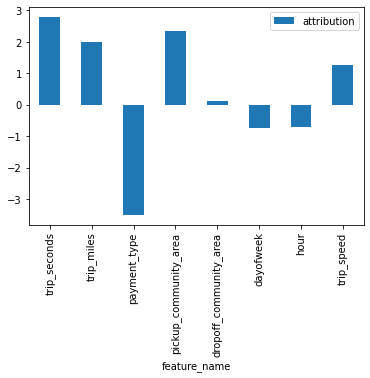

 explanation
  attribution
   baseline_output_value: 3.907447444588969
   instance_output_value: 7.553233762450805
   output_display_name: 
   approximation_error: 8.490226225376406e-19
   output_name: Predicted_taxi_fare
   output_index: -1


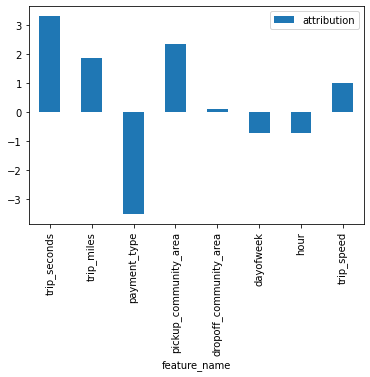

##########Predictions##########
7.479390476970966
7.553233762450805


In [208]:
features = X_train.columns.to_list()

def plot_attributions(attrs):
    """
    Function to plot the features and their attributions for an instance
    """
    rows = {"feature_name": [], "attribution": []}
    for i, val in enumerate(features):
        rows["feature_name"].append(val)
        rows["attribution"].append(attrs["Input_feature"][i])
    attr_df = pd.DataFrame(rows).set_index("feature_name")
    attr_df.plot(kind="bar")
    plt.show()
    return


def explain_tabular_sample(
    project: str, location: str, endpoint_id: str, instances: list
):
    """
    Function to make an explanation request for the specified payload and generate feature attribution plots
    """
    aiplatform.init(project=project, location=location)

    endpoint = aiplatform.Endpoint(endpoint_id)

    response = endpoint.explain(instances=instances)
    print("#" * 10 + "Explanations" + "#" * 10)
    for explanation in response.explanations:
        print(" explanation")
        # Feature attributions.
        attributions = explanation.attributions

        for attribution in attributions:
            print("  attribution")
            print("   baseline_output_value:", attribution.baseline_output_value)
            print("   instance_output_value:", attribution.instance_output_value)
            print("   output_display_name:", attribution.output_display_name)
            print("   approximation_error:", attribution.approximation_error)
            print("   output_name:", attribution.output_name)
            output_index = attribution.output_index
            for output_index in output_index:
                print("   output_index:", output_index)

            plot_attributions(attribution.feature_attributions)

    print("#" * 10 + "Predictions" + "#" * 10)
    for prediction in response.predictions:
        print(prediction)

    return response


test_json = [X_test.iloc[0].tolist(), X_test.iloc[1].tolist()]
prediction = explain_tabular_sample(PROJECT, LOCATION, ENDPOINT_ID, test_json)

## Next Steps

The Chicago-Taxicab dataset is continuously updating so the same kind of analysis and model training can be applied every time a new set of data is available. The date range can also be increased from a week to a month or more depending on the quality of data. Most of the
steps in this notebook can be applied to new data unless the data is too noisy. Therefore, any new data needs to be checked for outliers, edge cases, etc. The model needs to be prepared for unknown outliers, missing data, or any other conditions that are too complex to learn.
The notebook can also be scheduled to run at the specified times to retrain the model using the scheduling option of the [Vertex-AI workbench's Executor feature](https://console.cloud.google.com/vertex-ai/workbench/list/executions).

## Clean Up
<a name="section-10"></a>

Delete the resources created in this notebook.

Undeploy the model by specifying the `DEPLOYED_MODEL_ID`.

In [218]:
endpoint.undeploy(deployed_model_id=DEPLOYED_MODEL_ID)

INFO:google.cloud.aiplatform.models:Undeploying Endpoint model: projects/931647533046/locations/us-central1/endpoints/4735051223063855104
INFO:google.cloud.aiplatform.models:Undeploy Endpoint model backing LRO: projects/931647533046/locations/us-central1/endpoints/4735051223063855104/operations/6792843378259132416
INFO:google.cloud.aiplatform.models:Endpoint model undeployed. Resource name: projects/931647533046/locations/us-central1/endpoints/4735051223063855104


Delete the endpoint resource.

In [219]:
endpoint.delete()

INFO:google.cloud.aiplatform.base:Deleting Endpoint : projects/931647533046/locations/us-central1/endpoints/4735051223063855104
INFO:google.cloud.aiplatform.base:Delete Endpoint  backing LRO: projects/931647533046/locations/us-central1/operations/77976333849722880
INFO:google.cloud.aiplatform.base:Endpoint deleted. . Resource name: projects/931647533046/locations/us-central1/endpoints/4735051223063855104


Delete the model resource.

In [220]:
model.delete()

INFO:google.cloud.aiplatform.base:Deleting Model : projects/931647533046/locations/us-central1/models/8770694303606374400
INFO:google.cloud.aiplatform.base:Delete Model  backing LRO: projects/931647533046/locations/us-central1/operations/920149464168005632
INFO:google.cloud.aiplatform.base:Model deleted. . Resource name: projects/931647533046/locations/us-central1/models/8770694303606374400


Remove the contents of the created Cloud Storage bucket.

In [221]:
! gsutil -m rm -r $BUCKET_NAME